In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import sys
import os

import iceutils as ice
import jax.numpy as jnp
import jax
  
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, Predictive

import arviz as az

print(os.environ['JAX_ENABLE_X64'])

True


/Users/briel/miniforge3/envs/ice/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model(u=None, u_x=None, h=None, D=None, Cm=None, Td=None, Tb_obs=None):

    # Physical constants
    B0 = 400.0
    n = 3.0
    W = 30.0e3
    scale = 1.0
    N = u_x.shape[0]

    # Set priors
    theta = numpyro.sample('theta', dist.MultivariateNormal(jnp.zeros((N,)), covariance_matrix=Cm))
    
     # Compute B
    B = B0 * jnp.exp(theta)

    # Effective viscosity 
    strain = jnp.abs(u_x) + 1.0e-5
    nu = B / (strain**((n - 1.0) / n))

    # Longitudinal stress
    Tm = scale * 2.0 * jnp.dot(D, h * nu * u_x)

    # Lateral drag
    absu = jnp.abs(u)
    usign = u / absu
    Tl = (2.0 * scale / W) * usign * h * B * (5 * absu / W)**(1.0 / n)

    # Compute drag mean predictions (this should nominally be zero for ice shelves)
    Tb = Tm - Tl + Td

    # Data likelihood: use a slightly larger data variance here in order to get comparable
    # variance in the posterior predictions to the VGP predictions
    numpyro.sample('Tb', dist.Normal(Tb_obs, 5.0), obs=Tb)


In [3]:
def run_inference(model, rng_key, u, u_x, h, D, Cm, Td, Tb_obs):
    
    # Run inference
    kernel = NUTS(model, dense_mass=True)
    num_samples = 3000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
    mcmc.run(rng_key, u=u, u_x=u_x, h=h, D=D, Cm=Cm, Td=Td, Tb_obs=Tb_obs)
    
    # Run posterior predictive sampling
    posterior_samples = mcmc.get_samples()
    posterior_predictive = Predictive(model, posterior_samples)(
        jax.random.PRNGKey(2), u=u, u_x=u_x, h=h, D=D, Cm=Cm, Td=Td,
    )
    
    # Run prior predictive sampling
    prior = Predictive(model, num_samples=1000)(
        jax.random.PRNGKey(3), u=u, u_x=u_x, h=h, D=D, Cm=Cm, Td=Td,
    )
    
    # Aggregate data
    post = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_predictive)
    
    return post

Number of points: 392


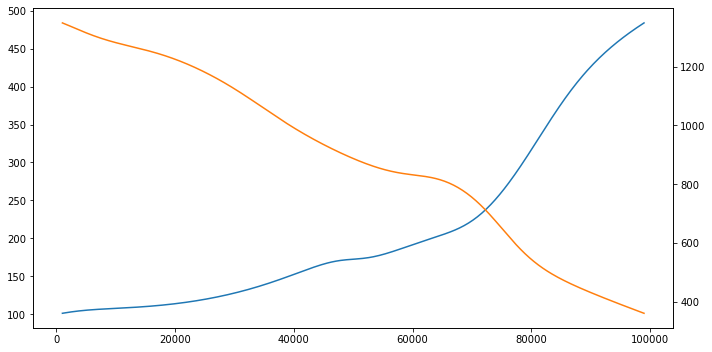

In [4]:
# Initialize profile data
x, B_ref = ice.h5read('data_noise.h5', ['x', 'B_ref'])
# For consistency, use neural net predictions for surface variables
u, h = ice.h5read('output_predictions.h5', ('u', 'h'))

# Truncate edges to avoid smoothing artifacts
truncate = True
if truncate:
    mask = (x > 1.0e3) * (x < 99.0e3)
    x, u, h, B_ref = [arr[mask] for arr in (x, u, h, B_ref)]
N = x.size
print('Number of points:', N)

# Construct finite difference matrix
D = ice.sim.construct_finite_diff_matrix(x, edge_order=2)

rho_ice = 917.0
rho_water = 1024.0
g = 9.80665
scale = 1.0

# Compute gradients
u_x = np.dot(D, u)
h_x = np.dot(D, h)

# Surface gradients can be computed from hydrostatic assumption
s_x = h_x * (1.0 - rho_ice / rho_water)
alpha = -1.0 * s_x

# Driving stresses (scale to kPa since viscosity units give kPa)
Td = scale * 1.0e-3 * rho_ice * g * h * alpha
Tb_obs = np.zeros_like(u)

# Convert everything to jax arrays
D, u, u_x, h_x, Td, Tb_obs = [jnp.array(arr) for arr in
                           (D, u, u_x, h_x, Td, Tb_obs)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, u, color='C0')
ax2 = ax.twinx()
ax2.plot(x, h, color='C1')
plt.tight_layout()

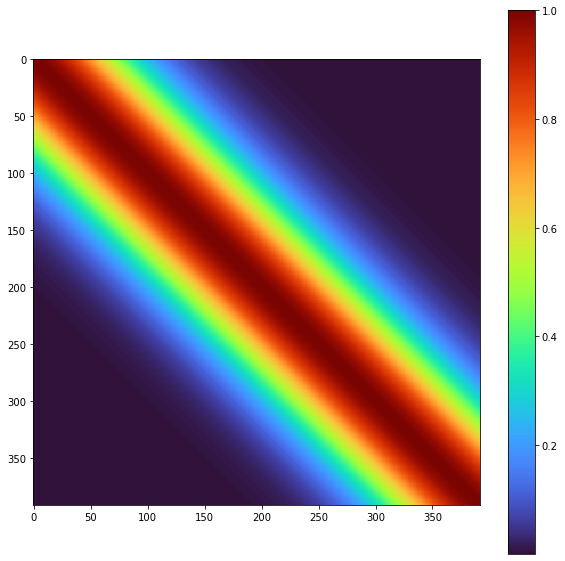

In [5]:
# Create prior covariance matrix - distance based smoothing
distance= np.sqrt((x[:, None] - x[None, :])**2)

L = 15.0e3
sigma = 1.0
Cm = sigma**2 * np.exp(-distance**2 / (2.0 * L**2))
Cm[range(N), range(N)] += 1.0e-6

# Quick check for positive definiteness
t = np.linalg.cholesky(Cm)
Cm = jnp.array(Cm)

plt.figure(figsize=(10, 10))
plt.imshow(Cm, cmap='turbo', interpolation='nearest')
plt.colorbar()

In [6]:
# Initialize RNG
rng_key = jax.random.PRNGKey(21)

# Run inference
post = run_inference(model, rng_key, u, u_x, h, D, Cm, Td, Tb_obs)

sample: 100%|█████████| 4000/4000 [00:50<00:00, 79.66it/s, 15 steps of size 9.38e-02. acc. prob=0.87]


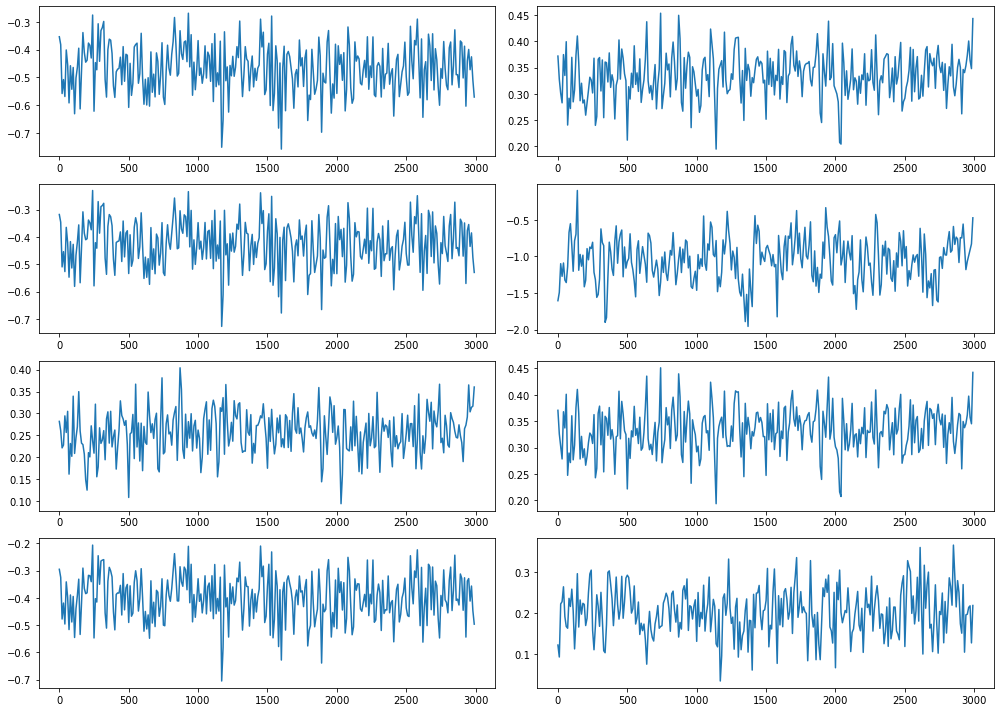

In [7]:
burnin = 0
thin = 1
samples = post.posterior.theta.data.squeeze()[burnin::thin]
count = np.arange(samples.shape[0])

logB0 = np.log(400.0)
B_samples = np.exp(logB0 + samples)
B_mean = np.mean(B_samples, axis=0)
B_std = np.std(B_samples, axis=0)

# Save samples
with h5py.File('samples_mcmc.h5', 'w') as fid:
    fid['x'] = x
    fid['u'] = u
    fid['h'] = h
    fid['B_ref'] = B_ref
    fid['theta_samples'] = samples
    fid['B_samples'] = B_samples

# Random traces
inds = np.random.choice(N, size=8, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))
sub = 10
for cnt, ind in enumerate(inds):
    ax = axes.ravel()[cnt]
    ax.plot(count[::sub], samples[::sub, ind])
plt.tight_layout()

393.00039721127956


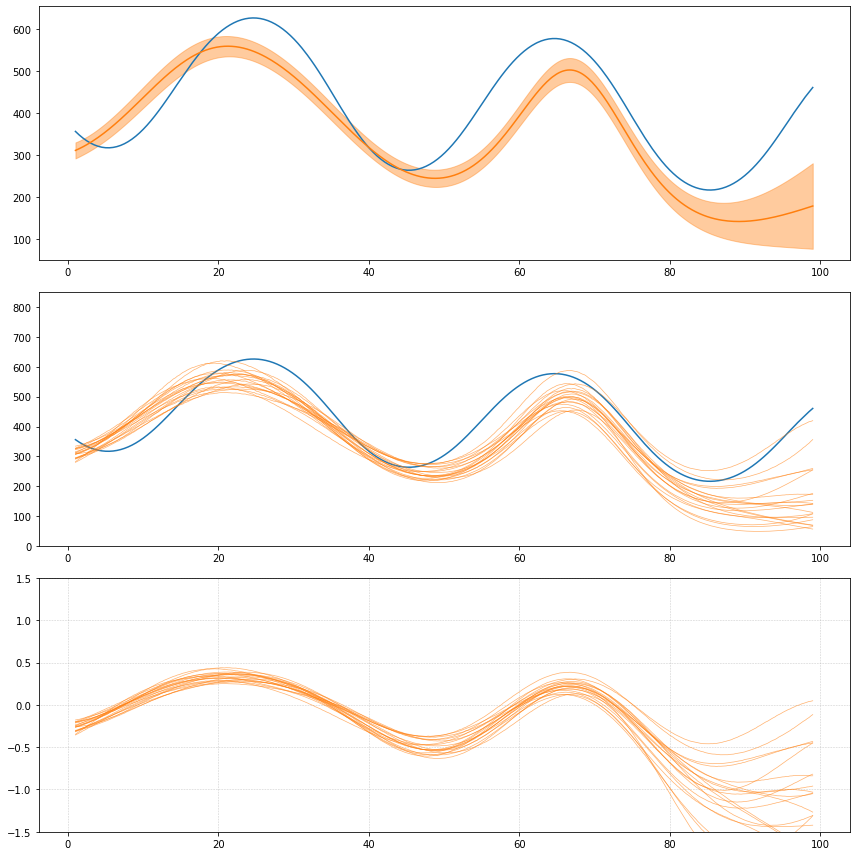

In [8]:
# Stats
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 12))

print(np.median(B_ref))

#x = np.arange(x.size)
ax1.plot(1.0e-3*x, B_ref)
line, = ax1.plot(1.0e-3*x, B_mean)
ax1.fill_between(1.0e-3*x, B_mean - B_std, B_mean + B_std, alpha=0.4, color=line.get_color())

ax2.plot(1.0e-3*x, B_ref)
for i in np.arange(0, B_samples.shape[0], B_samples.shape[0] // 20, dtype=int):
    ax2.plot(1.0e-3*x, B_samples[i], '-', color='C1', lw=0.7, alpha=0.6)
    ax3.plot(1.0e-3*x, samples[i], '-', color='C1', lw=0.7, alpha=0.6)

ax2.set_ylim(0, 850)
ax3.set_ylim(-1.5, 1.5)
ax3.grid(True, ls=':', lw=0.6)
fig.set_tight_layout(True)

Prior drag std: 23.96236177581884
Posterior drag std: 2.004557592760976


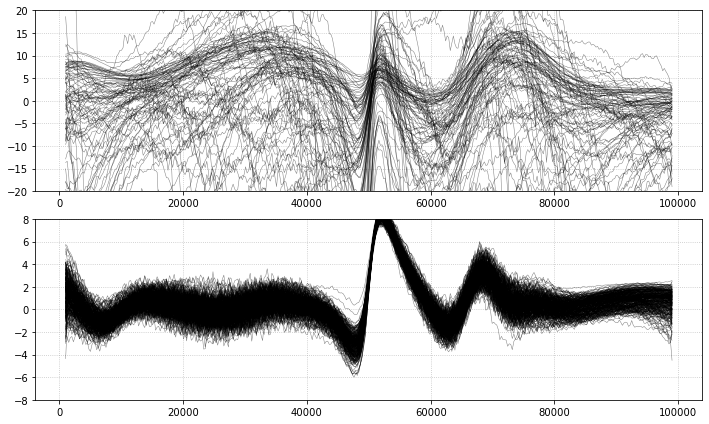

In [9]:
Tb_prior = post.prior_predictive.Tb.data.squeeze()
Tb_post = post.posterior_predictive.Tb.data.squeeze()

print('Prior drag std:', np.std(Tb_prior))
print('Posterior drag std:', np.std(Tb_post))

Tb_post_mean = np.mean(Tb_post, axis=0)
Tb_post_std = np.std(Tb_post, axis=0)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))

ax1.plot(x, Tb_prior[::10].T, '-k', lw=0.5, alpha=0.5)
ax1.set_ylim(-20, 20)

ax2.plot(x, Tb_post[::10].T, '-k', lw=0.5, alpha=0.5)
ax2.set_ylim(ax1.get_ylim())
ax2.set_ylim(-8, 8)

for ax in (ax1, ax2):
    ax.grid(True, ls=':', alpha=0.8)

fig.set_tight_layout(True)

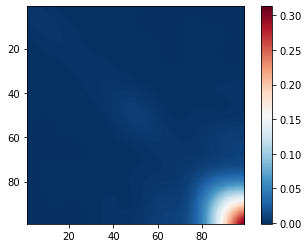

In [10]:
# Covariance on normalized samples
C = np.cov(samples, rowvar=False)

extent = 1.0e-3 * np.array([x[0], x[-1], x[-1], x[0]])

plt.imshow(C, interpolation='nearest', cmap='RdBu_r', extent=extent)
plt.colorbar()